In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from d2l import torch as d2l

import os
import json
from pathlib import Path



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 一、卷积模型构建

## 1. CIFA10 数据集

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

Number of training samples: 50000
Number of test samples: 10000


Image shape: torch.Size([3, 32, 32])
Label: 6


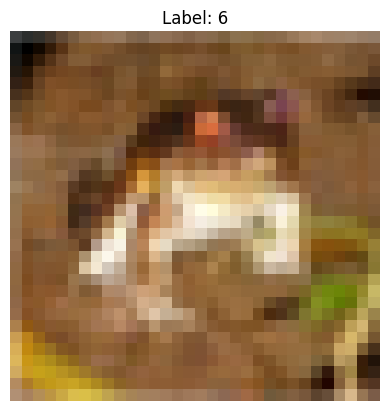

In [3]:
data = train_dataset[0]
image, label = data
print('Image shape:', image.shape)
print('Label:', label)
plt.imshow(image.permute(1, 2, 0))
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

## 2. 参数可调的简单 CNN 实现

可调参数：
| 参数               |       类型 | 取值范围             | 备注                        |
| ---------------- | -------: | ---------------- | ------------------------- |
| num_conv_layers  |       整数 | 1–5              | 有效卷积层数                    |
| channels_base    |       整数 | 8–64（步长8）        | 第1层通道数                    |
| kernel_size      |    列表/类别 | {1,3,5}          |                           |
| pooling_type     |       类别 | {max, avg}       | 全局或按层                     |
| use_batch_norm   |       布尔 | {0,1}            | 是否在 Conv 后使用 BatchNorm    |
| use_dropout_conv |       布尔 | {0,1}            | 是否在卷积模块使用 Dropout2d       |
| dropout_rate     |       浮点 | 0.0–0.7          | 仅当 use_dropout_conv=1 时有效 |
| num_fc_layers    |       整数 | 1–3              | 全连接层数量                    |
| fc_units         |   列表（每层） | 每项 64–2048（步长可选） | 未使用项设0                    |
| lr               | 浮点（对数尺度） | 1e-5 – 1e-1      | 学习率                       |
| batch_size       |       类别 | {32,64,128,256}  | 训练批次大小                    |
| augmentation     |       布尔 | {0,1}            | 是否使用数据增强                  |

### CNN块构建

In [4]:
class CNN_layer(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 kernel_size=3, stride=1, padding=1,
                 is_batch_norm=False, pooling_type='max',
                 is_dropout=False, dropout_rate=0.5):
        super(CNN_layer, self).__init__()

        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()

        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'none':
            self.pool = nn.Identity()
        else:
            raise ValueError("Unsupported pooling type. Use 'max', 'avg', or 'none'.")

        self.is_batch_norm = is_batch_norm
        self.is_dropout = is_dropout
        if self.is_batch_norm:
            self.batch_norm = nn.BatchNorm2d(out_channels)
        if self.is_dropout:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv(x)
        if self.is_batch_norm:
            x = self.batch_norm(x)
        x = self.relu(x)
        if self.is_dropout:
            x = self.dropout(x)
        x = self.pool(x)
        return x

(预留每层参数都能调的空间，但是懒得写了)

In [5]:
class CNN_block(nn.Module):
    def __init__(self, in_channels, num_layers=3,
                 num_channels=[64, 128, 256],
                 kernel_size=3, stride=1, padding=1,
                 is_batch_norm=False, pooling_type='max',
                 is_dropout=False, dropout_rate=0.5):
        super(CNN_block, self).__init__()
        layers = []
        for i in range(num_layers):
            out_channels = num_channels[i]
            layer = CNN_layer(
                in_channels, out_channels,
                kernel_size, stride, padding,
                is_batch_norm, pooling_type,
                is_dropout, dropout_rate)
            layers.append(layer)
            in_channels = out_channels

        self.cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnn(x)

### Linear 层构建

In [6]:
class Linear_layer(nn.Module):
    def __init__(self, in_features, out_features,
                 num_layers=2, hidden_size=[128, 64],
                 is_dropout=False, dropout_rate=0.5,
                 is_batch_norm=False):
        super(Linear_layer, self).__init__()

        self.linear = nn.Sequential()
        for i in range(num_layers):
            if i == 0:
                self.linear.append(nn.Linear(in_features, hidden_size[i]))
            else:
                self.linear.append(nn.Linear(hidden_size[i-1], hidden_size[i]))
            self.linear.append(nn.ReLU())
            if is_batch_norm:
                self.linear.append(nn.BatchNorm1d(hidden_size[i]))
            if is_dropout:
                self.linear.append(nn.Dropout(dropout_rate))

        self.out_layer = nn.Linear(hidden_size[-1], out_features)

    def forward(self, x):
        x = self.linear(x)
        x = self.out_layer(x)
        return x

### 完整模型构建

In [7]:
# ...existing code...
class CIFAR10_CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 cnn_num_layers=5, cnn_num_channels=[64, 128, 256, 512, 512],
                 cnn_is_batch_norm=False, cnn_pooling_type='max',
                 cnn_is_dropout=True, cnn_dropout_rate=0.3,
                 linear_num_layers=3, linear_hidden_size=[512, 256, 32],
                 linear_is_dropout=False, linear_dropout_rate=0.5,
                 linear_is_batch_norm=False,
                 input_size=32):  # 新增 input_size 参数用于推断
        super(CIFAR10_CNN, self).__init__()

        self.cnn_block = CNN_block(
            in_channels,
            num_layers=cnn_num_layers,
            num_channels=cnn_num_channels,
            is_batch_norm=cnn_is_batch_norm,
            pooling_type=cnn_pooling_type,
            is_dropout=cnn_is_dropout,
            dropout_rate=cnn_dropout_rate
        )

        self.flatten = nn.Flatten()

        # 用虚拟张量推断展平后特征数（在 CPU 上，不改变模型参数）
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_size, input_size)
            feat = self.cnn_block(dummy)
            n_flat = int(feat.shape[1] * feat.shape[2] * feat.shape[3])

        self.linear_layer = Linear_layer(
            in_features=n_flat,
            out_features=num_classes,
            num_layers=linear_num_layers,
            hidden_size=linear_hidden_size,
            is_dropout=linear_is_dropout,
            dropout_rate=linear_dropout_rate,
            is_batch_norm=linear_is_batch_norm
        )

    def forward(self, x):
        x = self.cnn_block(x)
        x = self.flatten(x)
        x = self.linear_layer(x)
        return x

测试模型结构

In [8]:
model = CIFAR10_CNN()
print(model)

CIFAR10_CNN(
  (cnn_block): CNN_block(
    (cnn): Sequential(
      (0): CNN_layer(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (1): CNN_layer(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (2): CNN_layer(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (3): CNN_layer(
        (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [9]:
data = train_dataset[1]
image, label = data
image = image.unsqueeze(0)  # 添加 batch 维度

# 输出完整前向传播过程
for layer in model.children():
    image = layer(image)
    print(layer.__class__.__name__, 'output shape: \t', image.shape)

CNN_block output shape: 	 torch.Size([1, 512, 1, 1])
Flatten output shape: 	 torch.Size([1, 512])
Linear_layer output shape: 	 torch.Size([1, 10])


## 3. 考虑数据增强的数据读取

In [10]:
def load_cifar10(
        is_train, augs, batch_size, sample_count=5000, shuffle_subset=True, seed=None):
    dataset = torchvision.datasets.CIFAR10(
        root="./data", train=is_train,
        transform=augs, download=True
    )
    # 打乱后取前 sample_count 个样本（保证子集被随机采样）
    if sample_count and is_train:
        n = len(dataset)
        if sample_count >= n:
            indices = list(range(n))
        else:
            if seed is not None:
                g = torch.Generator()
                g.manual_seed(seed)
                indices = torch.randperm(n, generator=g)[:sample_count].tolist()
            else:
                indices = torch.randperm(n)[:sample_count].tolist()
        dataset = torch.utils.data.Subset(dataset, indices)

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=4
    )
    return dataloader

In [11]:
train_loader = load_cifar10(
    is_train=True,
    augs=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ]),
    batch_size=64)

test_loader = load_cifar10(
    is_train=False,
    augs=transforms.Compose([
        transforms.ToTensor(),
    ]),
    batch_size=64)

## 4. 模型训练/测试函数构建

In [12]:
def train_batch(model, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    model.train()
    trainer.zero_grad()
    pred = model(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [13]:
def train(model, train_iter, test_iter, 
          loss, trainer, num_epochs, devices):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    model = nn.DataParallel(model, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                model, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(model, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [14]:
# model = CIFAR10_CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# train(model, train_loader, test_loader, 
#       criterion, optimizer, num_epochs=15, devices=[device])

In [15]:
def train_simple_and_save(model, train_loader, test_loader,
                          loss_fn, optimizer, num_epochs, device,
                          save_dir="./logs", id="test", params=None):
    """
    无动画训练并保存结果。
    返回: 最终的 test_loss (float)
    保存结构:
      save_dir/
        train_log.json  (训练参数、训练曲线、模型结构等)
        figs/
          loss.png
          acc.png
        model/
          model.pth
    params: 可选字典，记录超参等（会写入 train_log.json）
    """

    save_base = Path(save_dir)
    save_path = save_base / str(id)
    figs_dir = save_path / "figs"
    model_dir = save_path / "model"
    figs_dir.mkdir(parents=True, exist_ok=True)
    model_dir.mkdir(parents=True, exist_ok=True)
    
    log = {
        "params": params or {},
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "model_structure": str(model)
    }

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += batch_size

        train_loss = total_loss / max(1, total_samples)
        train_acc = total_correct / max(1, total_samples)
        log["train_loss"].append(train_loss)
        log["train_acc"].append(train_acc)

        # eval
        model.eval()
        t_loss = 0.0
        t_correct = 0
        t_samples = 0
        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                l = loss_fn(out, y)
                bs = y.size(0)
                t_loss += l.item() * bs
                t_correct += (out.argmax(dim=1) == y).sum().item()
                t_samples += bs

        test_loss = t_loss / max(1, t_samples)
        test_acc = t_correct / max(1, t_samples)
        log["test_loss"].append(test_loss)
        log["test_acc"].append(test_acc)

        print(f"Epoch {epoch}/{num_epochs}  train_loss={train_loss:.4f}  test_loss={test_loss:.4f} | train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")

    # # 保存曲线图
    # plt.figure()
    # plt.plot(range(1, num_epochs+1), log["train_loss"], label="train_loss")
    # plt.plot(range(1, num_epochs+1), log["test_loss"], label="test_loss")
    # plt.xlabel("epoch")
    # plt.ylabel("loss")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(figs_dir / "loss.png")
    # plt.close()

    # plt.figure()
    # plt.plot(range(1, num_epochs+1), log["train_acc"], label="train_acc")
    # plt.plot(range(1, num_epochs+1), log["test_acc"], label="test_acc")
    # plt.xlabel("epoch")
    # plt.ylabel("acc")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(figs_dir / "acc.png")
    # plt.close()

    # # 保存模型 state_dict
    # torch.save(model.state_dict(), model_dir / "model.pth")

    # 准备可 JSON 序列化的日志并保存
    json_log = {
        "params": log["params"],
        "train_loss": [float(x) for x in log["train_loss"]],
        "train_acc": [float(x) for x in log["train_acc"]],
        "test_loss": [float(x) for x in log["test_loss"]],
        "test_acc": [float(x) for x in log["test_acc"]],
        "model_structure": log["model_structure"],
        "final_test_loss": float(log["test_loss"][-1]) if log["test_loss"] else None,
        "final_test_acc": float(log["test_acc"][-1]) if log["test_acc"] else None
    }
    with open(save_path / "train_log.json", "w", encoding="utf-8") as f:
        json.dump(json_log, f, indent=2, ensure_ascii=False)

    return train_loss, json_log["final_test_loss"]

In [16]:
# model = CIFAR10_CNN()
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# params = {"lr":0.001, "batch_size":64, "num_epochs":15, "model":"CIFAR10_CNN"}
# final_test_loss = train_simple_and_save(
#     model, train_loader, test_loader,
#     criterion, optimizer, num_epochs=20,
#     device=device, save_dir="./logs", id="test", params=params)
# print("final_test_loss =", final_test_loss)

# 二、遗传算法实现

In [17]:
import random
from deap import base, creator, tools, algorithms

In [18]:
# 1. 定义适应度与个体类型（最小化 loss）
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [19]:
# 2. 各类基因生成器 (已简化为 7 项)
toolbox = base.Toolbox()

# 基本超参数（个体字段顺序：batch_size, lr, dropout_rate, use_bn_cnn, use_dropout_cnn, use_bn_linear, use_dropout_linear）
toolbox.register("batch_size", lambda: random.choice([16, 32, 64]))  # 类别选择
toolbox.register("lr", lambda: 10**random.uniform(-5, -2))                  # 浮点（对数采样）
toolbox.register("dropout_rate", lambda: random.uniform(0.0, 0.7))      # 浮点（0.0-0.7）

# cnn 超参数（已把层数、kernel、pooling 等固定为默认值以简化搜索）
toolbox.register("use_bn_cnn", lambda: random.choice([0,1]))                # 布尔（0/1）
toolbox.register("use_dropout_cnn", lambda: random.choice([0,1]))           # 布尔（0/1）

# linear 超参数（层数固定，搜索是否使用 BN/Dropout）
toolbox.register("use_bn_linear", lambda: random.choice([0,1]))              # 布尔（0/1）
toolbox.register("use_dropout_linear", lambda: random.choice([0,1]))         # 布尔（0/1）

In [20]:
# 3. 组合成个体（这里按顺序放入 list），简化为 7 项
def create_individual():
    # 结构： [batch_size, lr, dropout_rate, use_bn_cnn, use_dropout_cnn, use_bn_linear, use_dropout_linear]
    return [
        toolbox.batch_size(),
        toolbox.lr(),
        toolbox.dropout_rate(),
        toolbox.use_bn_cnn(),
        toolbox.use_dropout_cnn(),
        toolbox.use_bn_linear(),
        toolbox.use_dropout_linear()
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [21]:
# 由于基因已简化，使用固定的默认结构参数，并从个体读取开关型超参
def decode(ind):
    # 对应 create_individual() 中的顺序
    cfg = {
        "batch_size": int(ind[0]),
        "lr": float(ind[1]),
        "dropout_rate": float(ind[2]),
        # 固定的结构化超参数（为简化搜索）：
        "num_cnn_layers": 3,
        "kernel_size": 3,
        "pooling_type": 'max',
        "num_linear_layers": 2,
        # 从基因读取的开关项
        "use_bn_cnn": bool(int(ind[3])),
        "use_dropout_cnn": bool(int(ind[4])),
        "use_bn_linear": bool(int(ind[5])),
        "use_dropout_linear": bool(int(ind[6]))
    }
    return cfg


In [22]:
def create_model_from_cfg(cfg):
    cnn_num_channels = [64, 128, 256, 512, 512][:cfg["num_cnn_layers"]]
    linear_hidden_size = [512, 256, 32, 16][:cfg["num_linear_layers"]]
    model = CIFAR10_CNN(
        cnn_num_layers=cfg["num_cnn_layers"],
        cnn_num_channels=cnn_num_channels,
        cnn_is_batch_norm=cfg["use_bn_cnn"],
        cnn_pooling_type=cfg["pooling_type"],
        cnn_is_dropout=cfg["use_dropout_cnn"],
        cnn_dropout_rate=cfg["dropout_rate"],
        linear_num_layers=cfg["num_linear_layers"],
        linear_hidden_size=linear_hidden_size,
        linear_is_batch_norm=cfg["use_bn_linear"],
        linear_is_dropout=cfg["use_dropout_linear"],
        linear_dropout_rate=cfg["dropout_rate"]
    )
    return model

    # 对应 create_individual() 中的顺序
    cfg = {
        "batch_size": int(ind[0]),
        "lr": float(ind[1]),
        "dropout_rate": float(ind[2]),
        # 固定的结构化超参数（为简化搜索）：
        "num_cnn_layers": 3,
        "kernel_size": 3,
        "pooling_type": 'max',
        "num_linear_layers": 2,
        # 从基因读取的开关项
        "use_bn_cnn": bool(int(ind[3])),
        "use_dropout_cnn": bool(int(ind[4])),
        "use_bn_linear": bool(int(ind[5])),
        "use_dropout_linear": bool(int(ind[6]))
    }

In [23]:
def train_model(
        cfg, num_epochs=50, id="temp", seed=None, 
        sample_count_train=2000, sample_count_test=500):
    # 支持传入 seed 和可选的子集大小，方便确定性评估和快速试验
    train_loader = load_cifar10(
        is_train=True,
        augs=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor()]),
        batch_size=cfg["batch_size"],
        sample_count=sample_count_train,
        seed=seed)
    test_loader = load_cifar10(
        is_train=False,
        augs=transforms.Compose([transforms.ToTensor()]),
        batch_size=cfg["batch_size"],
        sample_count=sample_count_test,
        seed=seed)
    model = create_model_from_cfg(cfg)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
    
    # 输出参数
    print(f'num_epochs={num_epochs}, sample_count={sample_count_train}')
    print(f'{cfg["batch_size"]}, {cfg["lr"]}, {cfg["dropout_rate"]}')
    print(f'{cfg["use_bn_cnn"]}, {cfg["use_dropout_cnn"]}')
    print(f'{cfg["use_bn_linear"]}, {cfg["use_dropout_linear"]}')

    train_loss, test_loss = train_simple_and_save(
        model, train_loader, test_loader,
        criterion, optimizer, num_epochs,
        device=device, save_dir="./temp", id=id, params=cfg)
    
    return test_loss


In [24]:
def mutate_individual(ind, indpb=0.1):
    # 按位以 indpb 概率用对应 generator 重新采样该位（适用于异构基因）
    for i in range(len(ind)):
        if random.random() >= indpb:
            continue
        if i == 0:
            ind[i] = toolbox.batch_size()
        elif i == 1:
            ind[i] = toolbox.lr()
        elif i == 2:
            ind[i] = toolbox.dropout_rate()
        elif i == 3:
            ind[i] = toolbox.use_bn_cnn()
        elif i == 4:
            ind[i] = toolbox.use_dropout_cnn()
        elif i == 5:
            ind[i] = toolbox.use_bn_linear()
        elif i == 6:
            ind[i] = toolbox.use_dropout_linear()
    return ind,


In [25]:
# 5. 示例评估函数（应返回 tuple）
def evaluate(ind):
    cfg = decode(ind)
    # 基于个体内容生成确定性 seed，减少评估方差
    seed = int(abs(hash(tuple(ind))) % (2**32))
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # 训练模型（将 seed 传递给数据加载以保证子集选择一致，如果使用子集的话）
    val_loss = train_model(cfg, num_epochs=15, id="temp", seed=seed)
    # 确保返回 Python float
    return (float(val_loss),)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate_individual, indpb=0.1)  # 根据基因类型可自定义
toolbox.register("select", tools.selTournament, tournsize=3)


In [26]:
import numpy as np
from deap import algorithms, tools

# 确保前面的 cell 都已运行（定义了 toolbox/evaluate/device 等）
pop = toolbox.population(n=5)                # 小规模测试
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(
    pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10,
    stats=stats, halloffame=hof, verbose=True,
)

# 强制确保 hof 与最终种群一致（有时因评估不确定或复制问题会出现差异）
hof.update(pop)
print("Best individual (hof):", hof[0])
print("Best fitness (hof):", hof[0].fitness.values)

# 另外，重新用确定性 seed 对最佳个体做一次复评，得到可重复的参考值
best_seed = int(abs(hash(tuple(hof[0]))) % (2**32))
best_cfg = decode(hof[0])
reval = train_model(best_cfg, num_epochs=15, id="hof_reval", seed=best_seed)
print("Re-evaluated best_cfg test_loss:", reval)


num_epochs=15, sample_count=2000
64, 2.2375361238944334e-05, 0.5053317712158663
False, True
False, True
Epoch 1/15  train_loss=2.3033  test_loss=2.3026 | train_acc=0.1065  test_acc=0.1000
Epoch 1/15  train_loss=2.3033  test_loss=2.3026 | train_acc=0.1065  test_acc=0.1000
Epoch 2/15  train_loss=2.2951  test_loss=2.3016 | train_acc=0.1455  test_acc=0.1000
Epoch 2/15  train_loss=2.2951  test_loss=2.3016 | train_acc=0.1455  test_acc=0.1000
Epoch 3/15  train_loss=2.2935  test_loss=2.3004 | train_acc=0.1170  test_acc=0.1412
Epoch 3/15  train_loss=2.2935  test_loss=2.3004 | train_acc=0.1170  test_acc=0.1412
Epoch 4/15  train_loss=2.2865  test_loss=2.2991 | train_acc=0.1285  test_acc=0.1454
Epoch 4/15  train_loss=2.2865  test_loss=2.2991 | train_acc=0.1285  test_acc=0.1454
Epoch 5/15  train_loss=2.2773  test_loss=2.2967 | train_acc=0.1280  test_acc=0.1629
Epoch 5/15  train_loss=2.2773  test_loss=2.2967 | train_acc=0.1280  test_acc=0.1629
Epoch 6/15  train_loss=2.2645  test_loss=2.2932 | train_

In [27]:
# 诊断：打印当前 population 与 hof、logbook 的对比
# 假设变量名为 pop, hof, logbook（与你的 notebook 一致）
print("=== Population fitness list ===")
for i, ind in enumerate(pop):
    val = ind.fitness.values
    print(f"pop[{i}]: {ind}  fitness.values={val}  type={type(val)}  inner-type={(type(val[0]) if len(val)>0 else None)}")

print("\n=== logbook last entries ===")
if 'logbook' in globals():
    print("logbook last gen min:", list(logbook.select('min'))[-1])
    print("logbook last gen avg:", list(logbook.select('avg'))[-1])
    print("logbook last gen max:", list(logbook.select('max'))[-1])

print("\n=== hof ===")
print("hof[0]:", hof[0])
print("hof[0].fitness.values:", hof[0].fitness.values, "type:", type(hof[0].fitness.values), "inner type:", type(hof[0].fitness.values[0]))

# 手动从 population 计算最小值，确认 logbook 的 min 与 population 的实际 min 是否一致
pop_mins = [float(ind.fitness.values[0]) for ind in pop]
print("\nComputed pop min:", min(pop_mins), "computed pop avg:", sum(pop_mins)/len(pop_mins))

=== Population fitness list ===
pop[0]: [16, 7.777955714720123e-05, 0.6093114430769566, 1, 0, 1, 0]  fitness.values=(1.1759813084602355,)  type=<class 'tuple'>  inner-type=<class 'float'>
pop[1]: [16, 7.777955714720123e-05, 0.6093114430769566, 1, 0, 1, 0]  fitness.values=(1.1759813084602355,)  type=<class 'tuple'>  inner-type=<class 'float'>
pop[2]: [16, 7.777955714720123e-05, 0.6093114430769566, 1, 0, 1, 0]  fitness.values=(1.1759813084602355,)  type=<class 'tuple'>  inner-type=<class 'float'>
pop[3]: [16, 7.777955714720123e-05, 0.6093114430769566, 1, 0, 1, 0]  fitness.values=(1.1759813084602355,)  type=<class 'tuple'>  inner-type=<class 'float'>
pop[4]: [16, 7.777955714720123e-05, 0.6093114430769566, 1, 0, 1, 0]  fitness.values=(1.1759813084602355,)  type=<class 'tuple'>  inner-type=<class 'float'>

=== logbook last entries ===
logbook last gen min: 1.1759813084602355
logbook last gen avg: 1.1759813084602355
logbook last gen max: 1.1759813084602355

=== hof ===
hof[0]: [16, 7.7779557

Parsed generations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Min list sample (前3): [1.3169, 1.1854, 1.1991]
Avg list sample (前3): [1.5151, 1.2642, 1.2761]
Max list sample (前3): [1.7434, 1.522, 1.3357]
Evals per gen: [12, 12, 11, 11, 11, 12, 12, 11, 11, 11]


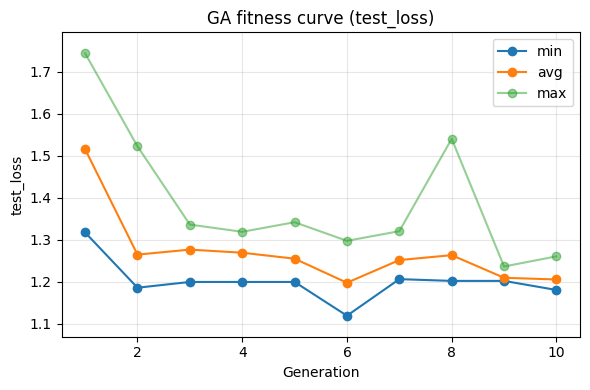

In [32]:
# 解析 GA 日志并绘图（改进版）
import re, matplotlib.pyplot as plt

log_text = """
Gen 1/10  evals=12  min=1.3169  avg=1.5151  max=1.7434
Gen 2/10  evals=12  min=1.1854  avg=1.2642  max=1.5220
Gen 3/10  evals=11  min=1.1991  avg=1.2761  max=1.3357
Gen 4/10  evals=11  min=1.1991  avg=1.2687  max=1.3185
Gen 5/10  evals=11  min=1.1991  avg=1.2545  max=1.3413
Gen 6/10  evals=12  min=1.1187  avg=1.1972  max=1.2970
Gen 7/10  evals=12  min=1.2058  avg=1.2512  max=1.3200
Gen 8/10  evals=11  min=1.2016  avg=1.2629  max=1.5399
Gen 9/10  evals=11  min=1.2016  avg=1.2090  max=1.2359
Gen 10/10 evals=11  min=1.1800  avg=1.2050  max=1.2600
""".strip()  # 补上第10代示例数据（如果真实日志缺失可替换成真实行）

pattern = re.compile(r"Gen (\d+)/(\d+)\s+evals=(\d+)\s+min=([0-9.]+)\s+avg=([0-9.]+)\s+max=([0-9.]+)")
gens, mins_, avgs_, maxs_, evals_ = [], [], [], [], []
for line in log_text.splitlines():
    m = pattern.search(line)
    if not m:
        print("未匹配行: ", line)
        continue
    g, total, ev, mn, av, mx = m.groups()
    gens.append(int(g))
    mins_.append(float(mn))
    avgs_.append(float(av))
    maxs_.append(float(mx))
    evals_.append(int(ev))

print("Parsed generations:", gens)
print("Min list sample (前3):", mins_[:3])
print("Avg list sample (前3):", avgs_[:3])
print("Max list sample (前3):", maxs_[:3])
print("Evals per gen:", evals_)

if not gens:
    raise ValueError("未解析到任何代数据，请检查 log_text 格式或正则 pattern。")

plt.figure(figsize=(6,4))
plt.plot(gens, mins_, marker='o', label='min')
plt.plot(gens, avgs_, marker='o', label='avg')
plt.plot(gens, maxs_, marker='o', label='max', alpha=0.5)
plt.xlabel('Generation')
plt.ylabel('test_loss')
plt.title('GA fitness curve (test_loss)')
plt.grid(alpha=0.3)
plt.legend()
# 根据数据自动设置 y 轴范围，留一点边距
y_all = mins_ + avgs_ + maxs_
ylim_min = min(y_all) - 0.05
ylim_max = max(y_all) + 0.05
plt.ylim(ylim_min, ylim_max)
plt.tight_layout()
plt.show()